<a href="https://colab.research.google.com/github/sobieddch90/mcd_udg_tfm-egg_analysis/blob/main/EEG%20Predictions%20-%20Epochs%20Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading and Prepare Data


Install Libraries & Download the

- Open Neuro: `pip install openneuro-py`
- MNE: `pip install mne`


In [1]:
%%capture
!pip install mne
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import json
import os
from google.colab import drive

import mne

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the Data


In [4]:
path = '/content/drive/MyDrive/EEG_Dataset/ds004504'
filename_part = 'participants.tsv'
df_partipants = pd.read_csv(path+'/'+filename_part, sep='\t')
df_partipants.head()

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22


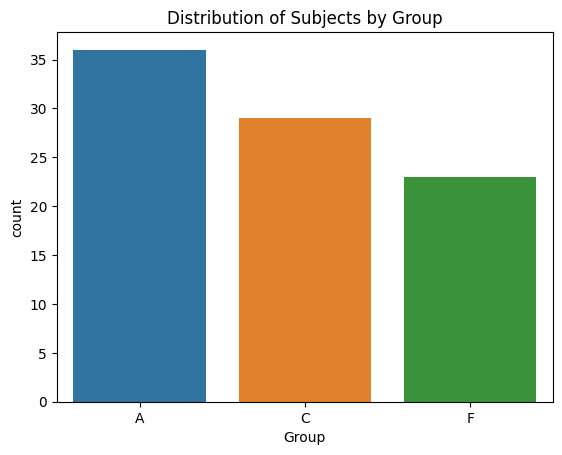

In [5]:
sns.countplot(x=df_partipants["Group"])
plt.title('Distribution of Subjects by Group')
plt.show()

In [6]:
path_derivatives = path+'/derivatives/'

dir_list = os.listdir(path_derivatives)
dir_list.sort()
print(len(dir_list))
print(dir_list[:5])

88
['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005']


In [7]:
eeg_data = []

for l in dir_list:
  folder = path_derivatives+l+'/eeg/'
  f = l+'_task-eyesclosed_eeg.set'
  #print(l)
  r = mne.io.read_raw_eeglab(folder+f, preload=False, verbose='CRITICAL')
  participant_info = {'id': l}
  r.info['subject_info'] = participant_info
  eeg_data.append(r)

print('EEG Files Loaded:',len(eeg_data))

EEG Files Loaded: 88


## Preselect Datasets


Show Maximum Time Distribution.


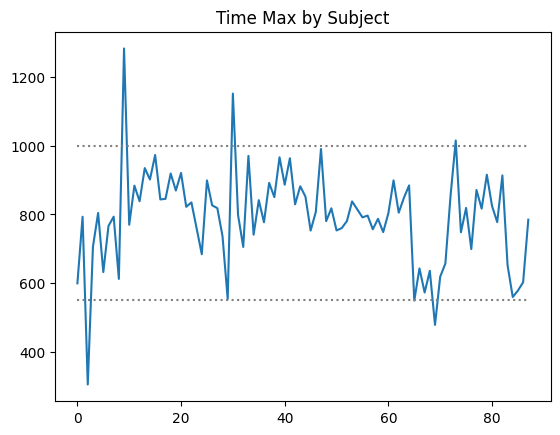

In [8]:
time_max = []

for r in eeg_data:
  time_max.append(r.tmax)

const_min = np.full(len(eeg_data),550)
const_max = np.full(len(eeg_data),1000)

plt.plot(time_max)
plt.plot(const_min, linestyle='dotted', c='gray')
plt.plot(const_max, linestyle='dotted', c='gray')

plt.title('Time Max by Subject')
plt.show()

Select Alzheimer and Fronto Temporal Dementia Subjects from Participants Info


In [9]:
df_ad_ftd = df_partipants[df_partipants['Group'].isin(['A','F'])]

# Encoding Gender, Groups (Classes)
gender_dict = {'M':0, 'F':1}
group_dict = {'A':0, 'F':1}

df_ad_ftd['Gender'] = df_ad_ftd['Gender'].replace(gender_dict)
df_ad_ftd['Group'] = df_ad_ftd['Group'].replace(group_dict)

print('Subjects from Alzheimer and Fronto Temporal Dementia datasets:',len(df_ad_ftd))
df_ad_ftd.head()

Subjects from Alzheimer and Fronto Temporal Dementia datasets: 59


<ipython-input-9-254eb9f5bfa6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ad_ftd['Gender'] = df_ad_ftd['Gender'].replace(gender_dict)
<ipython-input-9-254eb9f5bfa6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ad_ftd['Group'] = df_ad_ftd['Group'].replace(group_dict)


,participant_id,Gender,Age,Group,MMSE
0,sub-001,1,57,0,16
1,sub-002,1,78,0,22
2,sub-003,0,70,0,14
3,sub-004,1,67,0,20
4,sub-005,0,70,0,22


Filtering Subjects with raw data between 550 and 1000 seconds.


In [10]:
eeg_data_filtered = []
list_participants_id = []

for r in eeg_data:
  # filtering only Alzheimer and Fronto Temporal Dementia subjects
  if r.info['subject_info']['id'] in df_ad_ftd['participant_id'].tolist():
    if r.tmax >= 550:
      eeg_data_filtered.append(r)
      list_participants_id.append(r.info['subject_info']['id'])

df_ad_ftd = df_ad_ftd[df_ad_ftd['participant_id'].isin(list_participants_id)]

print('Participants Info:',len(df_ad_ftd))
print('EEG Data Subjects:',len(eeg_data_filtered))
df_ad_ftd.head()

Participants Info: 56
EEG Data Subjects: 56


,participant_id,Gender,Age,Group,MMSE
0,sub-001,1,57,0,16
1,sub-002,1,78,0,22
3,sub-004,1,67,0,20
4,sub-005,0,70,0,22
5,sub-006,1,61,0,14


Remove list of raw data to optimize usage of RAM

In [11]:
del eeg_data

# Feature Extraction


Epochs


In [12]:
start_time = 0
end_time = 550

duration = 60.0
overlapping = 20.0

epochs = []

for raw in eeg_data_filtered:
  ep = mne.make_fixed_length_epochs(raw.copy().crop(tmin=start_time, tmax=end_time),
                                    duration=duration, overlap=overlapping, preload=False, verbose='CRITICAL')
  epochs.append(ep)

print('Epochs created:', len(epochs))

Epochs created: 56


Using data from preloaded Raw for 13 events and 30000 original time points ...
0 bad epochs dropped
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated


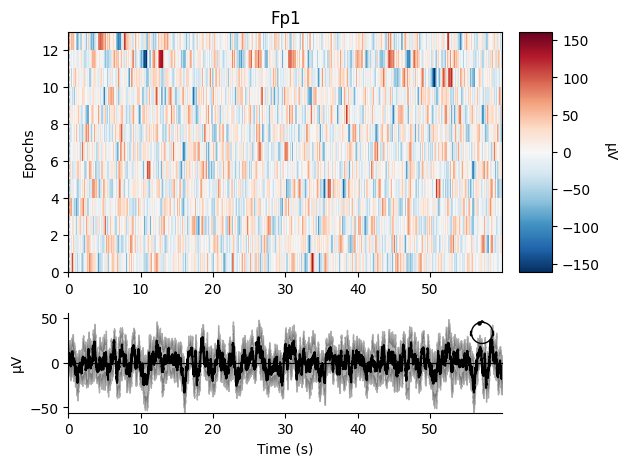

In [13]:
fig = epochs[0].plot_image(picks=["Fp1"])
plt.show()

In [14]:
epochs[0].get_data().shape

Using data from preloaded Raw for 13 events and 30000 original time points ...


(13, 19, 30000)

In [15]:
# Get features from Epochs (epochs)
features = []
for i, epoch in enumerate(epochs):
  n_epochs, n_channels, n_times = epoch.get_data().shape
  epoch_data = epoch.get_data().reshape(n_epochs, n_channels*n_times)
  features.append(epoch_data)

Using data from preloaded Raw for 13 events and 30000 original time points ...
Using data from preloaded Raw for 13 events and 30000 original time points ...
Using data from preloaded Raw for 13 events and 30000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 13 events and 30000 original time points ...
Using data from preloaded Raw for 13 events and 30000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 13 events and 30000 original time points ...
Using data from preloaded Raw for 13 events and 30000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 13 events and 30000 original time points ...
Using data from preloaded Raw for 13 events and 30000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 13 events and 30000 original time points ...
Using data from preloaded Raw for 13 events and 30000 original time points ...
0 bad epochs dropped
Using data from preloaded 

In [16]:
features[0].shape

(13, 570000)

In [17]:
len(features)

56

In [18]:
labels = df_ad_ftd['Group'].tolist()
len(labels)

56

Concatenate all Subjects Epochs and Adding Participants Info (Age, Gender, MMSE, Group)

In [19]:
for i in range(len(features)):
  f = features[i]
  data = df_ad_ftd.iloc[i][['Age','Gender']].tolist()
  additional_data = np.tile(data, (f.shape[0], 1))
  f = np.concatenate((f, additional_data), axis=1)
  features[i] = f

features[0].shape

(13, 570002)

Remove EEG Raw data filtered and Epochs List to free up space in RAM

In [20]:
del epochs
del eeg_data_filtered

## Train Test Split from Epochs

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train_concat = np.concatenate(X_train, axis=0)
X_test_concat = np.concatenate(X_test, axis=0)

y_train_concat = np.repeat(y_train, [array.shape[0] for array in X_train], axis=0)
y_test_concat = np.repeat(y_test, [array.shape[0] for array in X_test], axis=0)

print(X_train_concat.shape, len(y_train_concat))
print(X_test_concat.shape, len(y_test_concat))

(572, 570002) 572
(156, 570002) 156


In [22]:
del features

---


# Prediction

In [23]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

## XGBoost

In [25]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_concat, y_train_concat)

xgb_predict = xgb_classifier.predict(X_test_concat)

# Accuracy
accuracy = accuracy_score(y_test_concat, xgb_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## AdaBoost

In [25]:
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_concat, y_train_concat)

adaboost_predict = adaboost_classifier.predict(X_test_concat)

# Accuracy
accuracy = accuracy_score(y_test_concat, adaboost_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))